In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import mannwhitneyu

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
contig_lens = """
2R 61545105
3R 53200684
2L 49364325
UNKN 42389979
3L 41963435
X 24393108
Y_unplaced 237045
Mt 15363
"""

clens = dict([v.split(" ") for v in contig_lens.strip().split("\n")])

total_genome_len = sum([int(v) for k, v in clens.items()])

In [4]:
files = Path("..", "data", "sequencing_tech").glob("*csv")

In [5]:
seq_df = pd.concat([pd.read_csv(f, index_col=0, sep="\t") for f in files], axis=0)

In [6]:
seq_df.seq_tech.value_counts()

HiSeq     3130
HiSeqX    1563
Name: seq_tech, dtype: int64

In [7]:
seq_df.query("seq_tech == 'unsequenced'")

,seq_tech,ebi_sample_acc
derived_sample_id,,


In [8]:
bam_stats = pd.read_csv(
    Path("..", "data", "sequencing_tech", "vo_agam_indelrealign.bam_fix_mates_v2.metadata.tsv"),
    sep="\t", index_col=1)
join_df = bam_stats.join(seq_df)

In [9]:
join_df["bases_per_site"] = join_df.bases / total_genome_len
join_df["hit_target"] = join_df.bases_per_site >= 30

g = join_df.groupby("seq_tech")

In [10]:
bases = g.bases.agg([np.mean, np.median]) * 1e-9
bases

,mean,median
seq_tech,,
HiSeq,9.808061,9.765627
HiSeqX,11.000573,10.328453


In [11]:
g.reads.agg([np.mean, np.median])

,mean,median
seq_tech,,
HiSeq,1.036552e+08,102278528
HiSeqX,8.202439e+07,75209958


In [12]:
bases_per_site = g.bases_per_site.agg([np.mean, np.median])
bases_per_site

,mean,median
seq_tech,,
HiSeq,35.912617,35.757246
HiSeqX,40.279050,37.818055


In [13]:
g.hit_target.agg(np.mean)

seq_tech
HiSeq     0.805112
HiSeqX    0.918746
Name: hit_target, dtype: float64

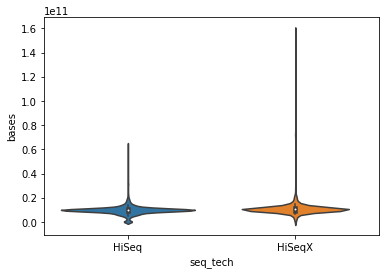

In [14]:
sns.violinplot(x="seq_tech", y="bases", data=join_df)

In [15]:
mannwhitneyu(g.get_group("HiSeq").bases, g.get_group("HiSeqX").bases)

MannwhitneyuResult(statistic=1937065.0, pvalue=1.349185998922192e-31)